# Mots

In [1]:
!pip install pandas
!pip install spacy
!pip install plotly
!pip install wordcloud

In [2]:
import pandas as pd
import spacy
from collections import Counter
import nltk
from nltk.probability import FreqDist
import plotly.express as px
import matplotlib.pyplot as plt

In [38]:
# Charger les données
df = pd.read_csv('labeled_data_with_predictions.csv')
df_date = pd.DataFrame(pd.read_excel('/home/onyxia/work/Scrapping_tweets/data_fin/tweets_fusionnes_removed.xlsx'))

# Charger le modèle SpaCy
nlp = spacy.load("en_core_web_sm")

# Stopwords personnalisés (ajouter ici les mots que vous voulez exclure)
custom_stopwords = {"https", "twitter", "elon", "musk", "people","quit","leave","stay", "like", "amp", "com", "user", "retweet", "go", "delete", "account","not"}

def clean_and_tokenize_spacy(text):
    """
    Utiliser SpaCy pour tokeniser et nettoyer le texte.
    """
    if not isinstance(text, str):
        return []
    doc = nlp(text.lower())
    tokens = [
        token.lemma_  # Récupérer le lemme (forme de base du mot)
        for token in doc
        if not token.is_stop  # Exclure les stopwords de SpaCy
        and token.is_alpha  # Exclure les caractères non alphabétiques
        and token.lemma_ not in custom_stopwords  # Exclure les mots personnalisés
    ]
    return tokens

# Appliquer le nettoyage et la tokenisation avec SpaCy
df['tokens'] = df['cleaned_tweet'].apply(clean_and_tokenize_spacy)

In [39]:
liste = []
for ligne in df['tokens']:
    liste = liste + ligne
liste = [token for token in liste if len(token) > 1]

In [40]:
fdist = FreqDist(liste)
fd = pd.DataFrame(fdist.most_common(30), columns = ["Word","Frequency"]).drop([0]).reindex()
fig = px.bar(fd, x="Word", y="Frequency")
fig.update_traces(marker_color='rgb(240,128,128)',marker_line_color='rgb(8,48,107)',marker_line_width=1.5, opacity=0.8)
fig.show()

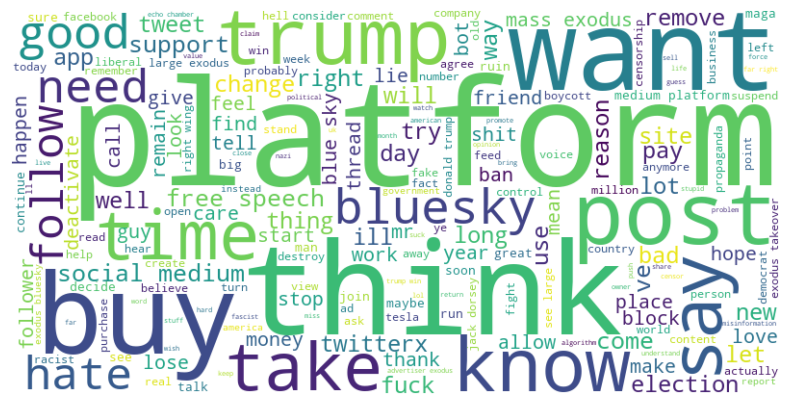

In [41]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(liste)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


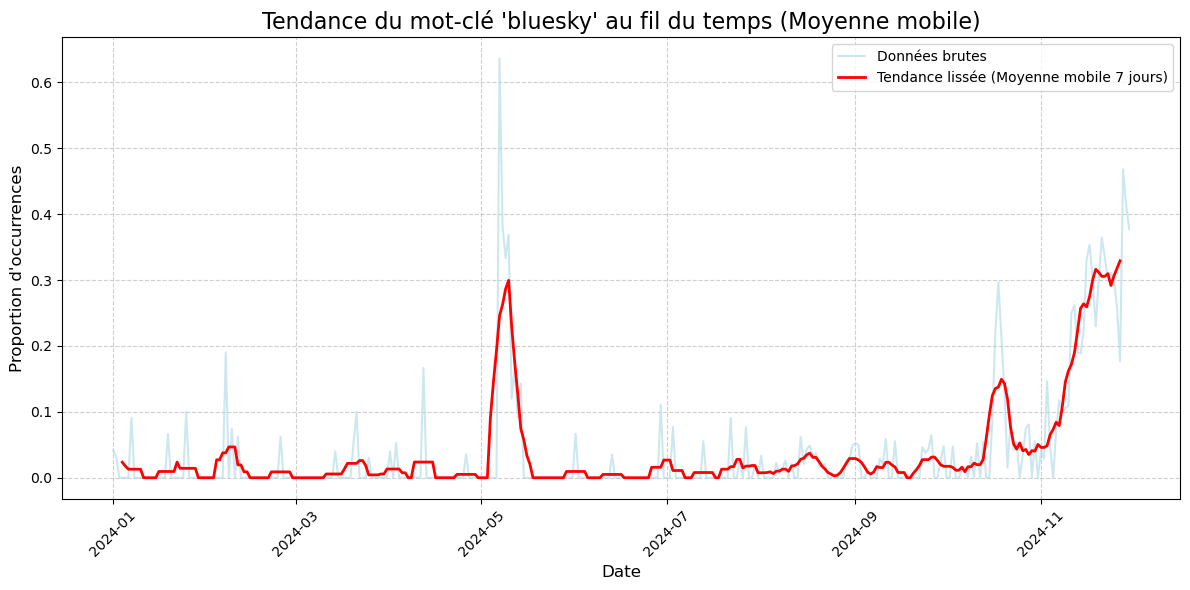

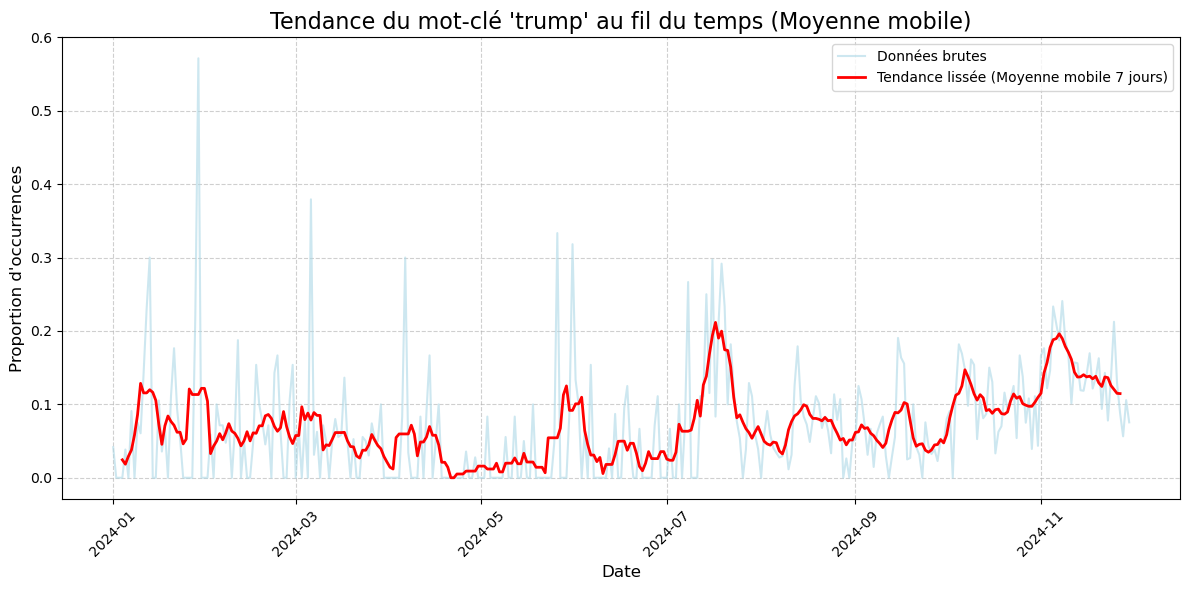

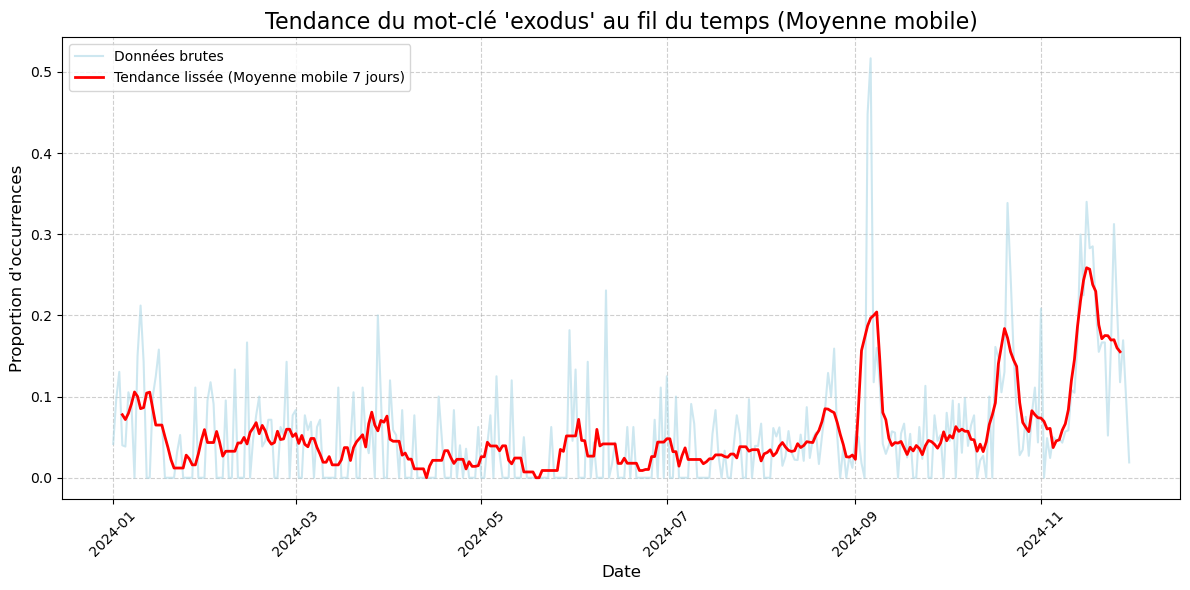

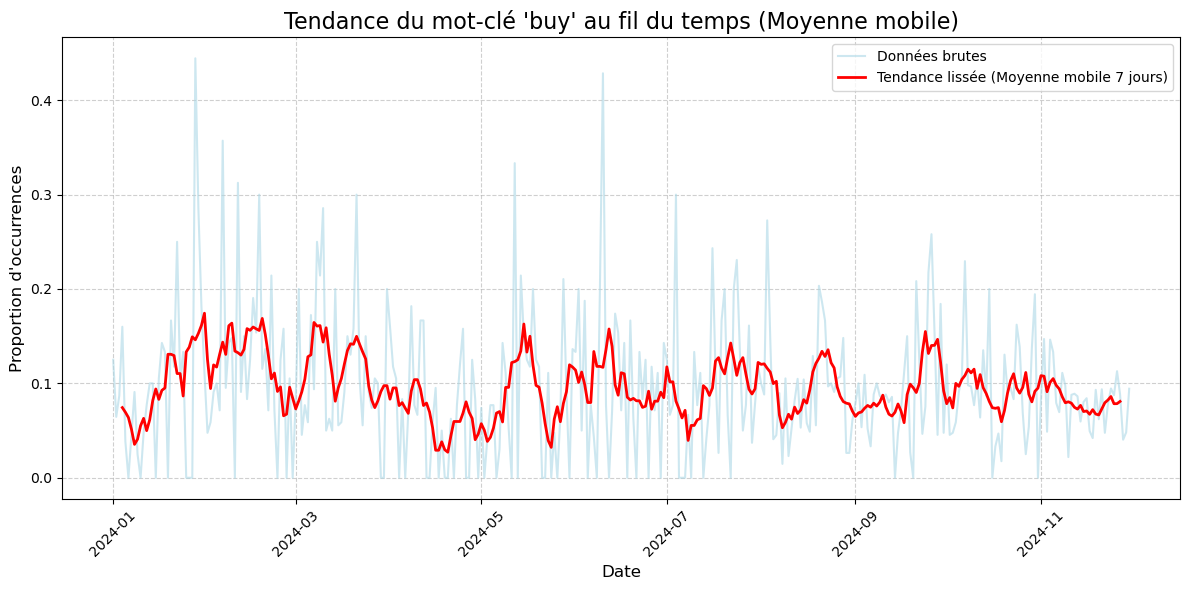

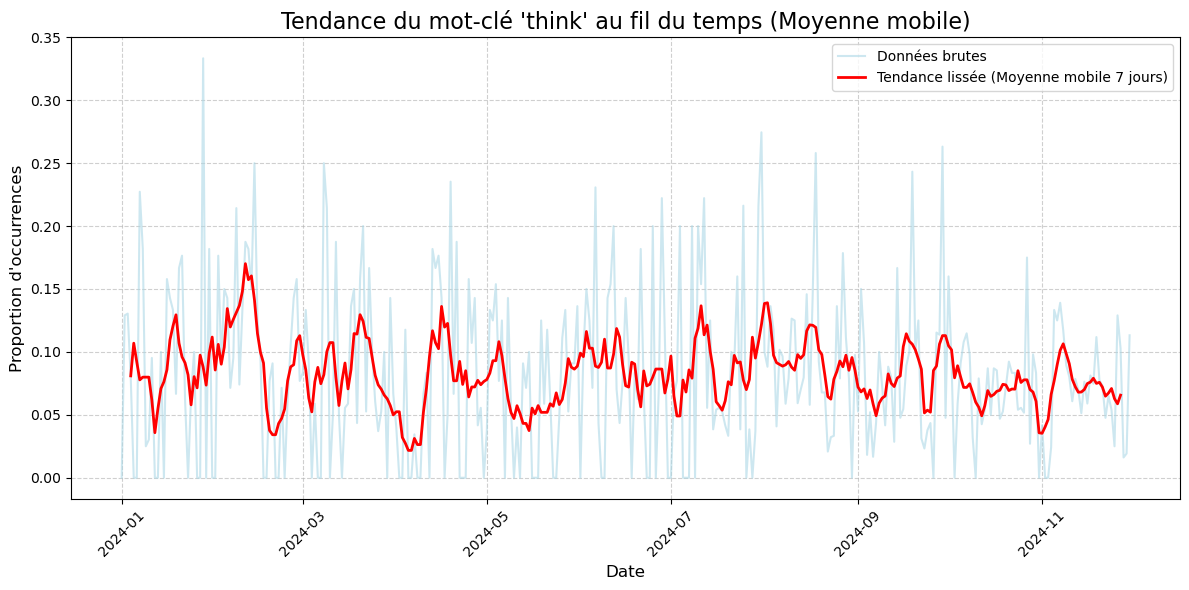

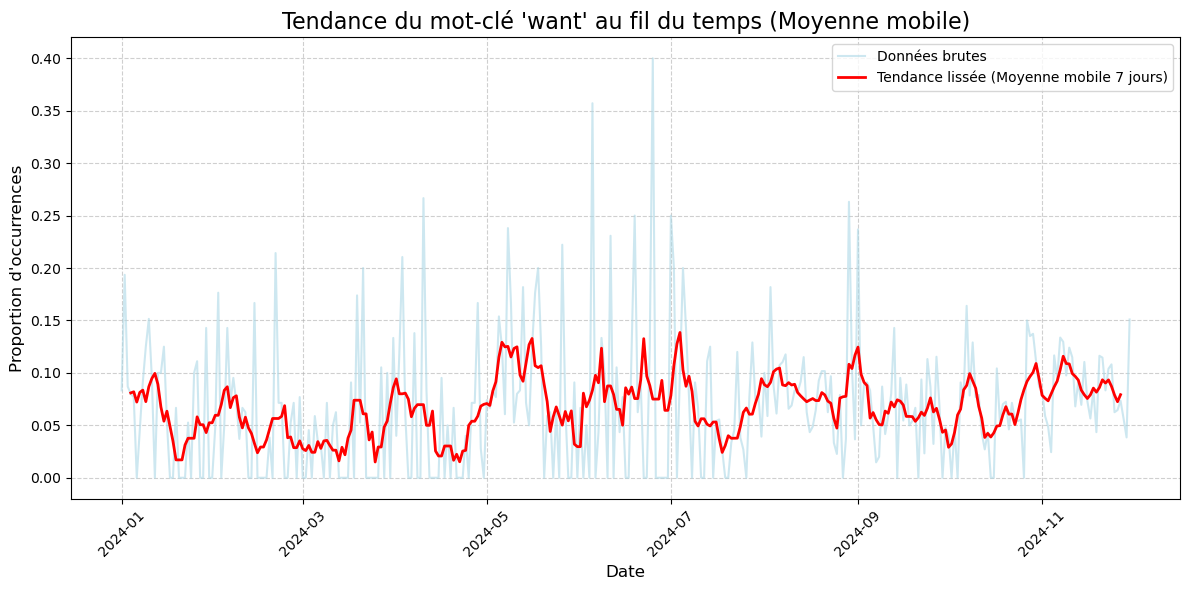

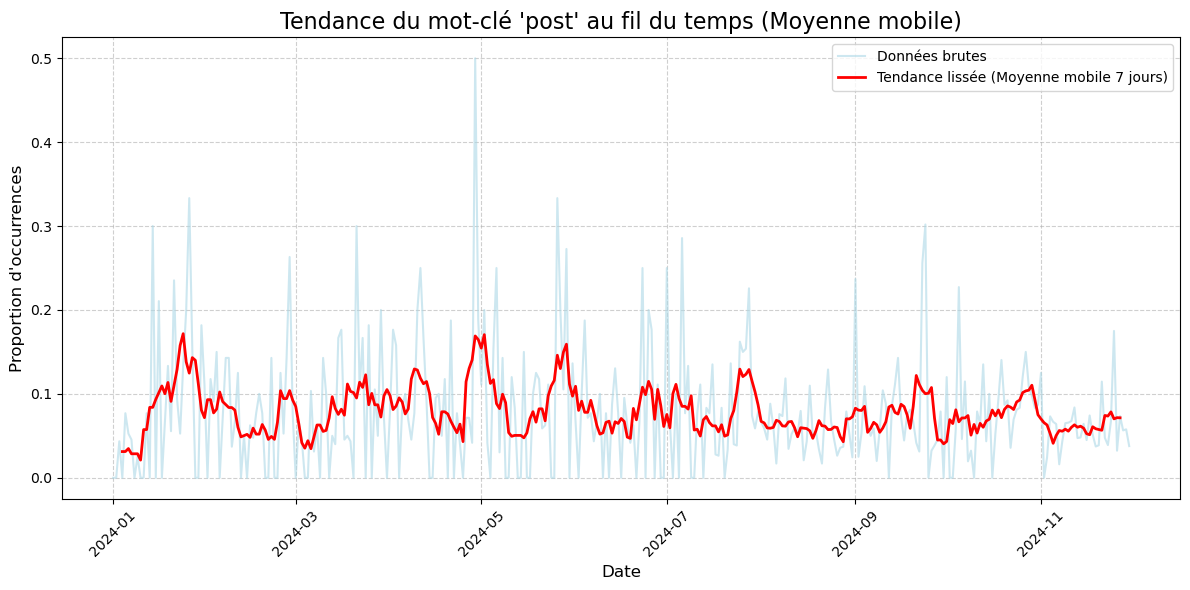

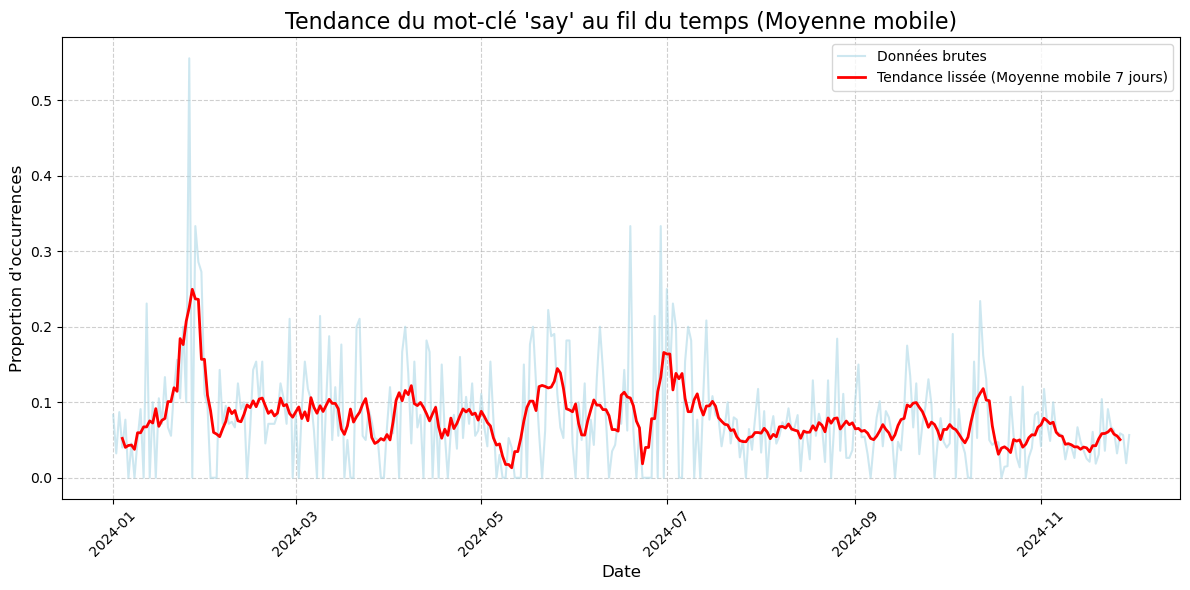

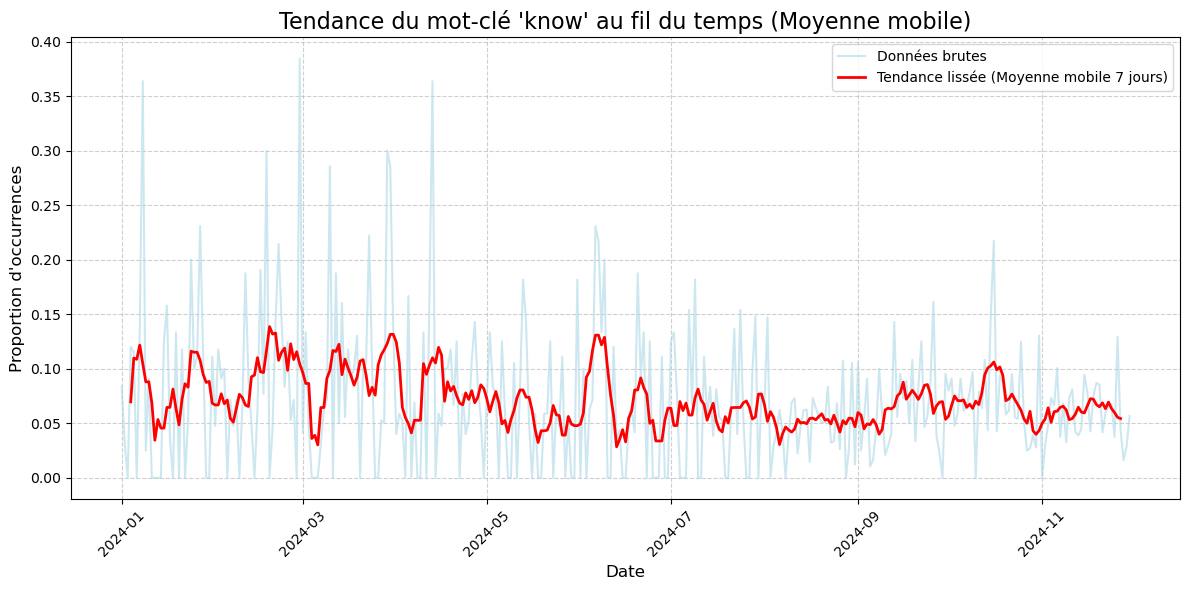

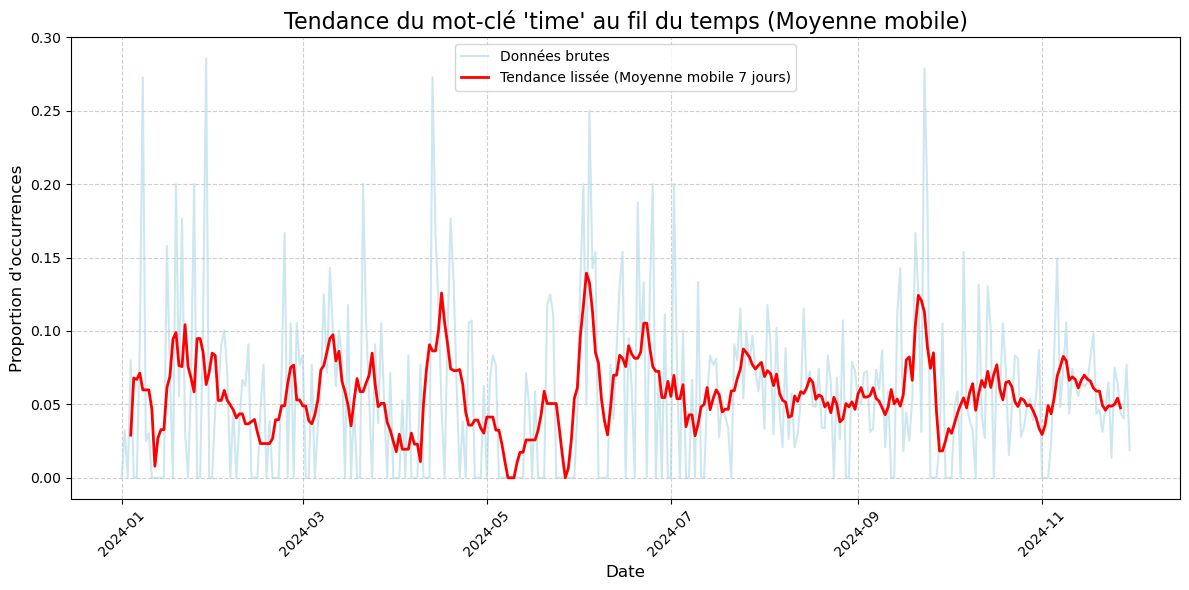

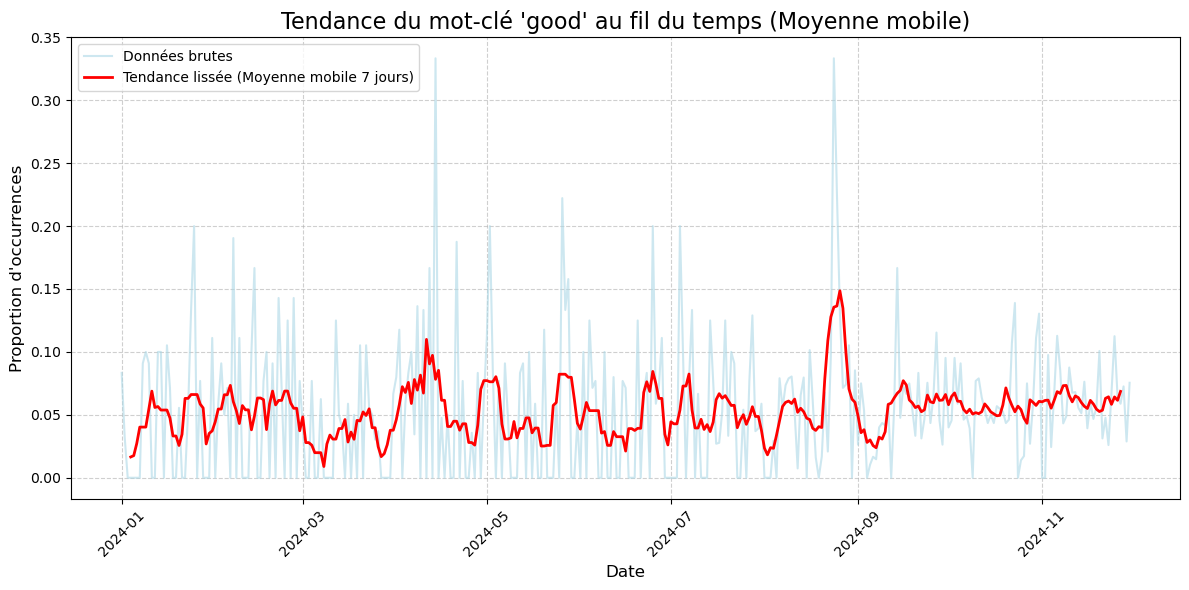

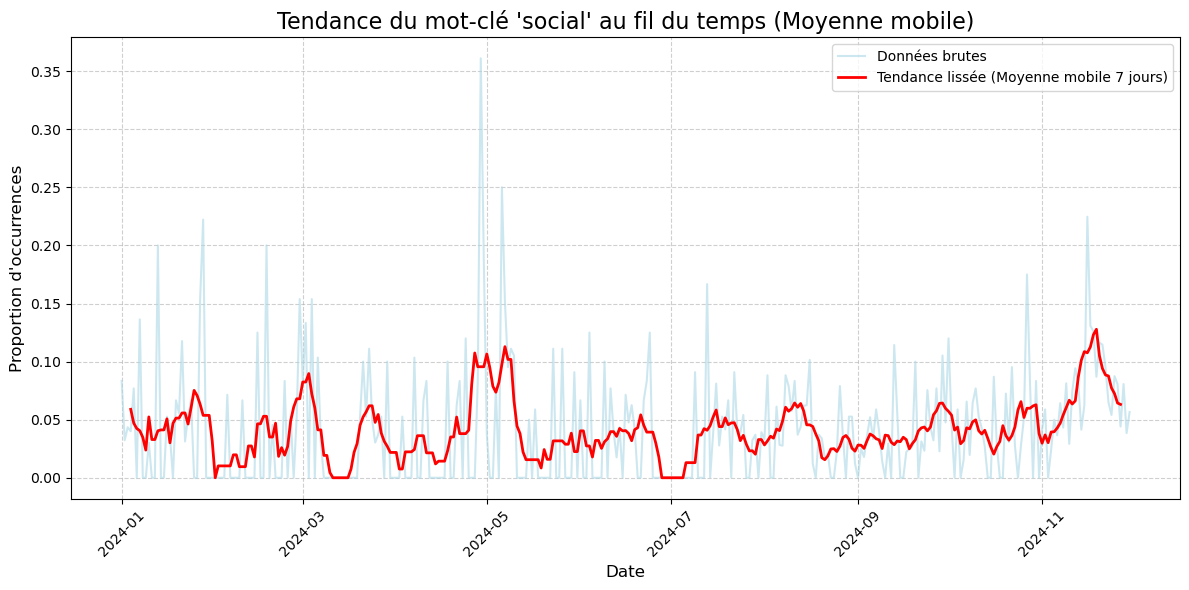

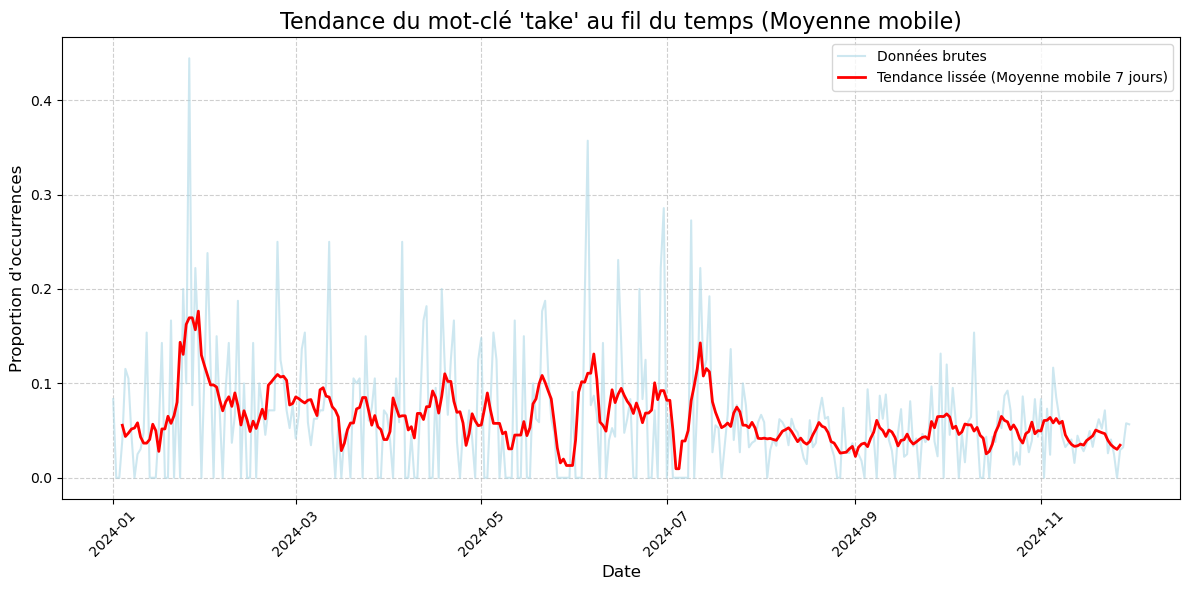

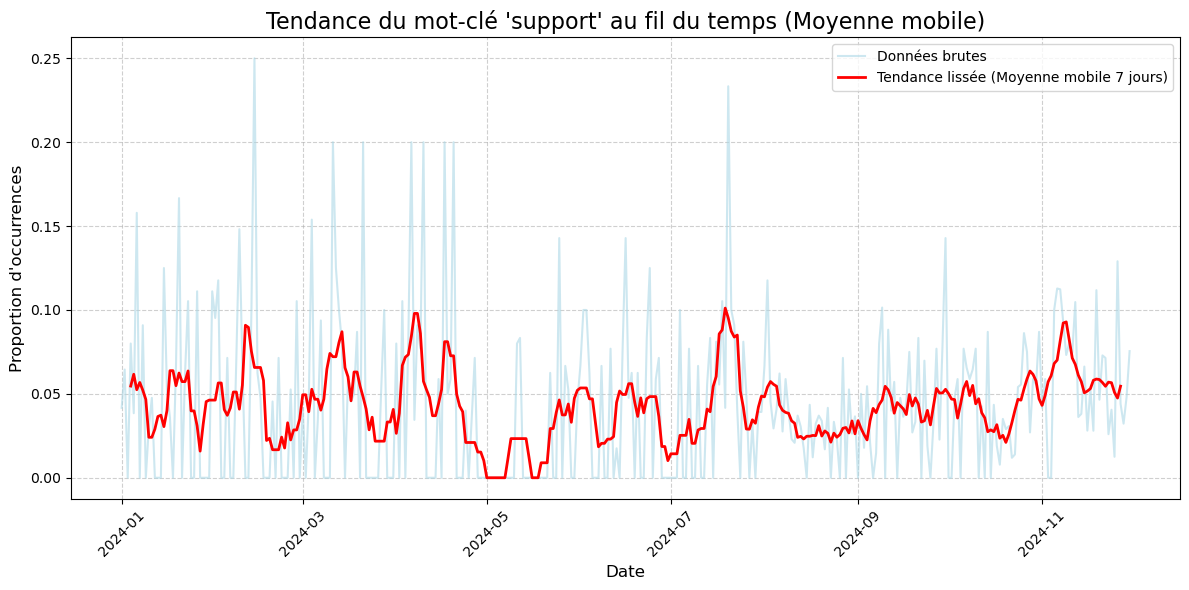

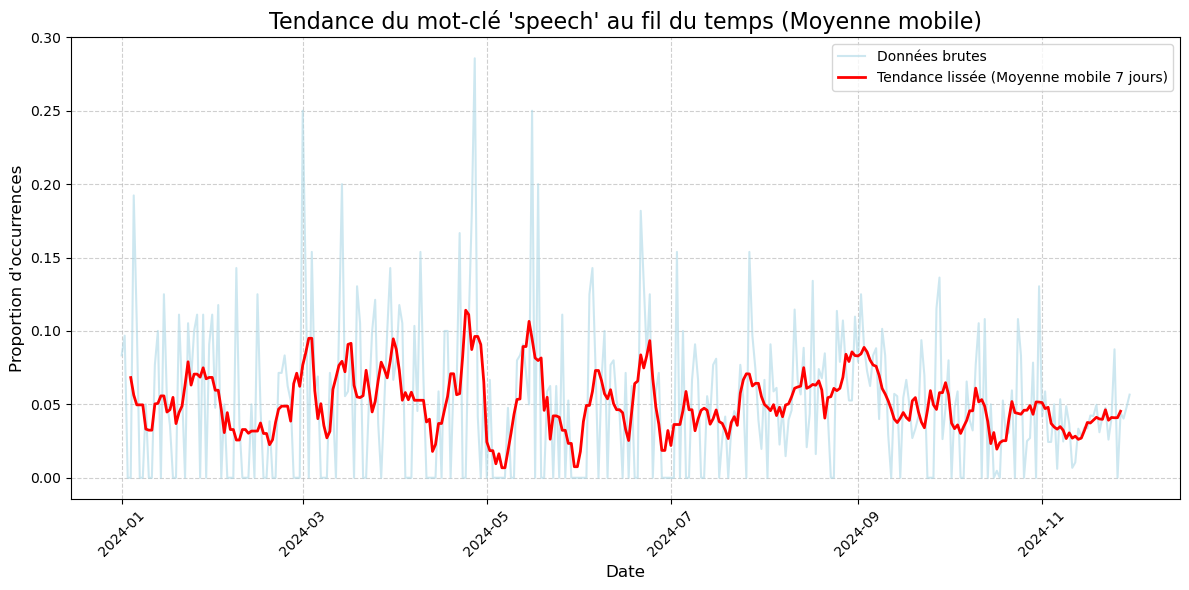

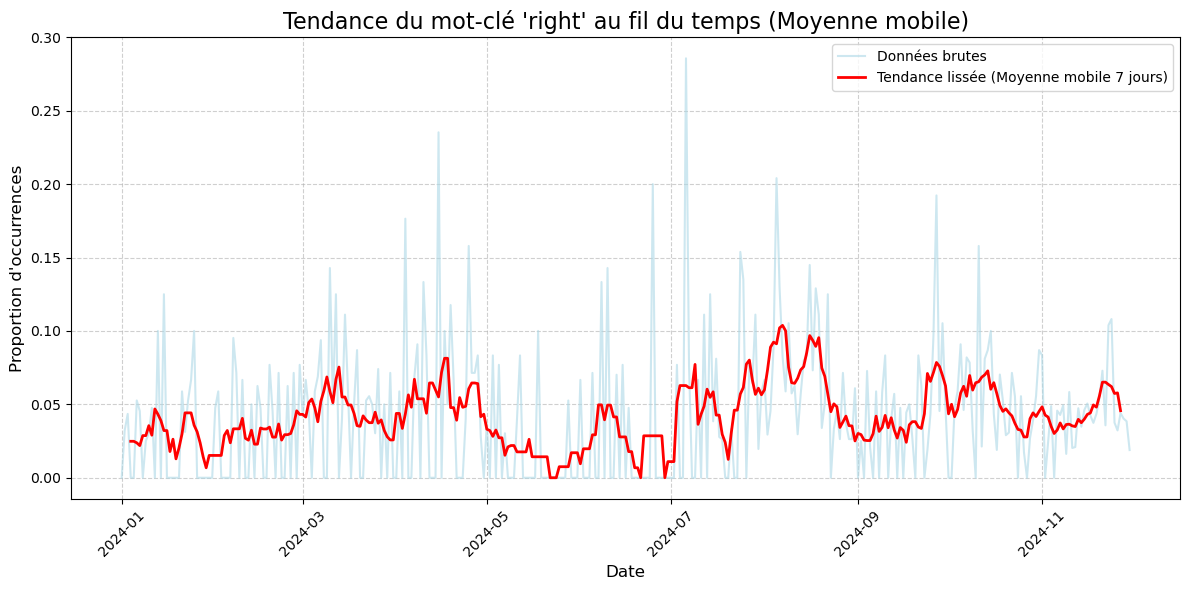

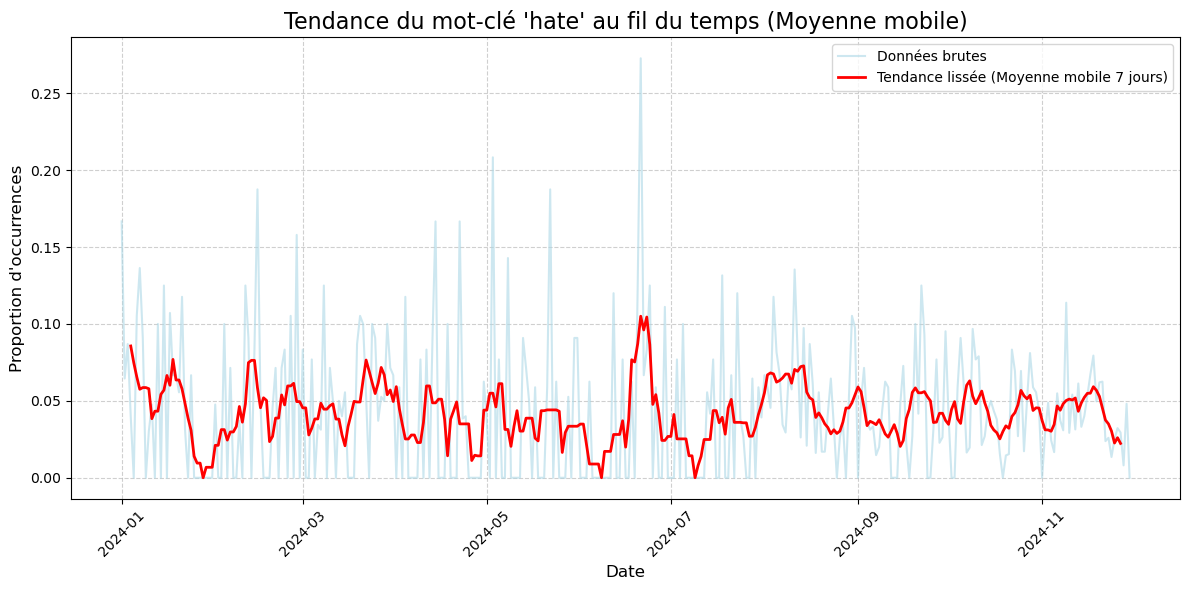

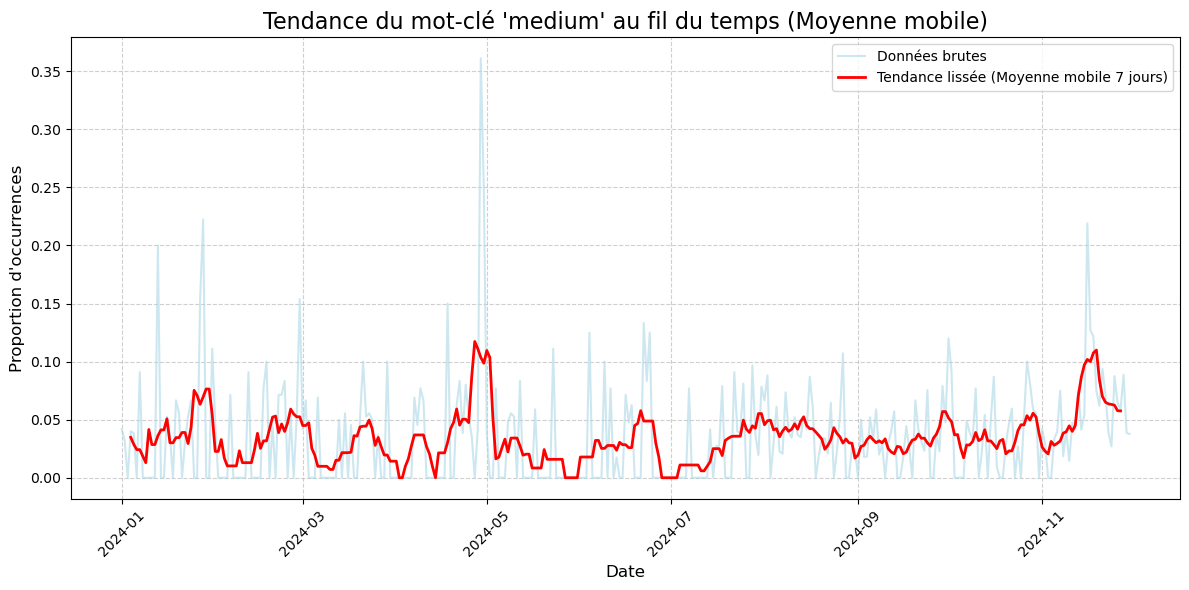

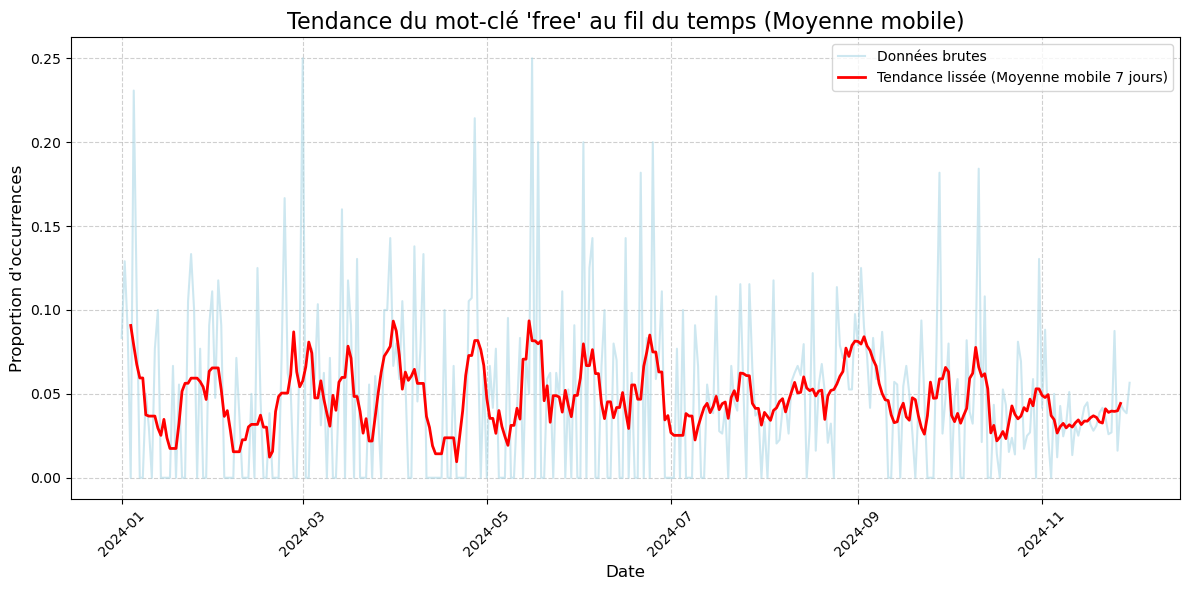

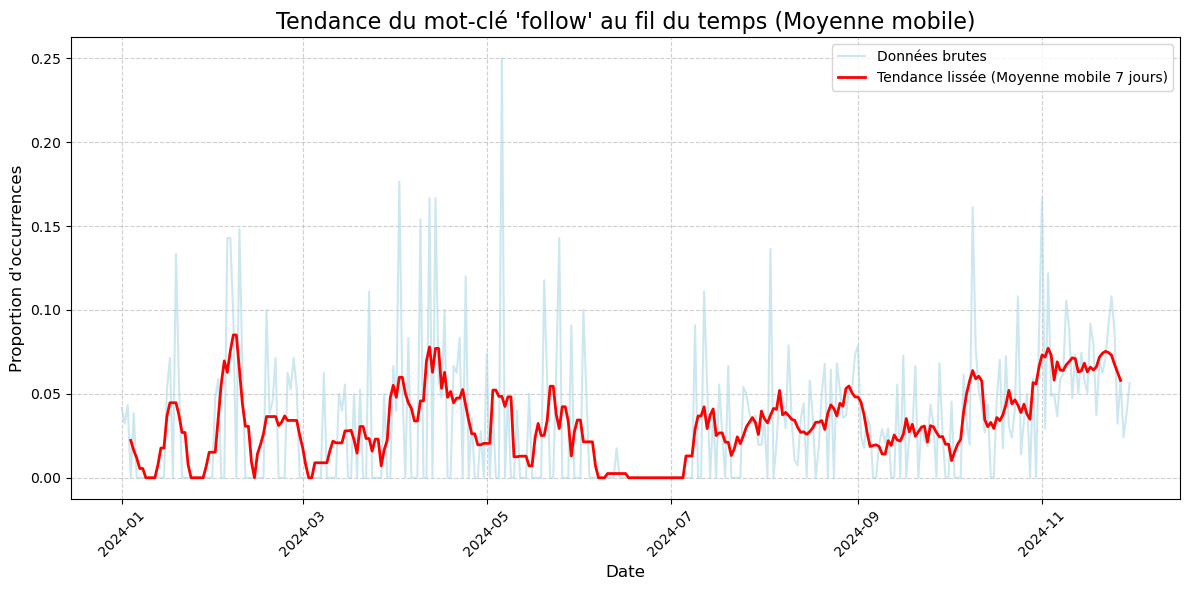

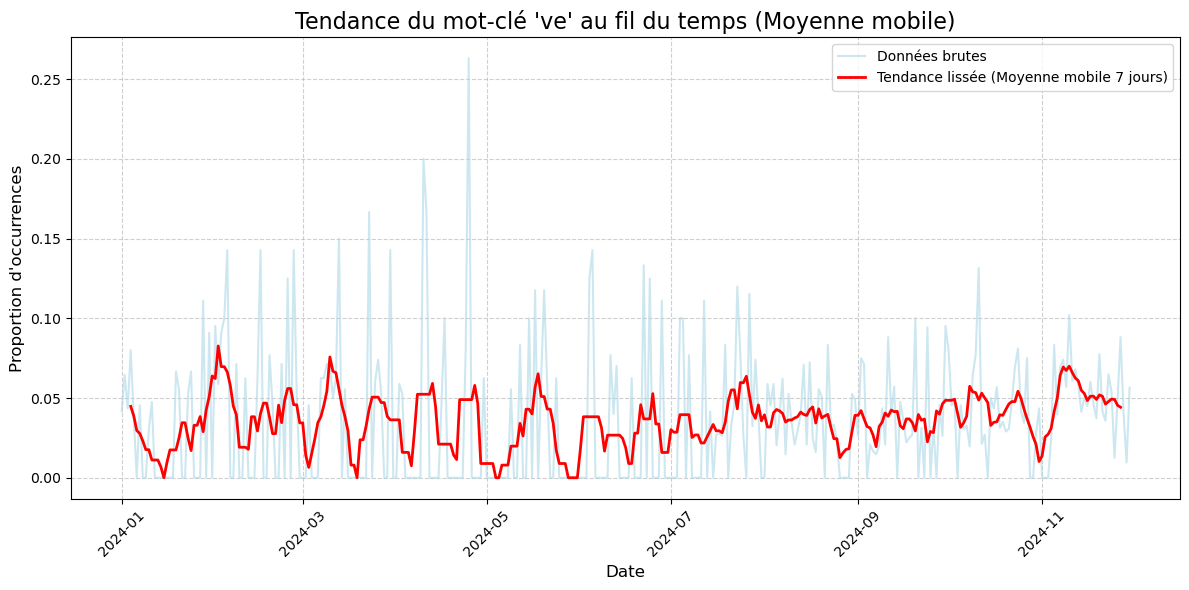

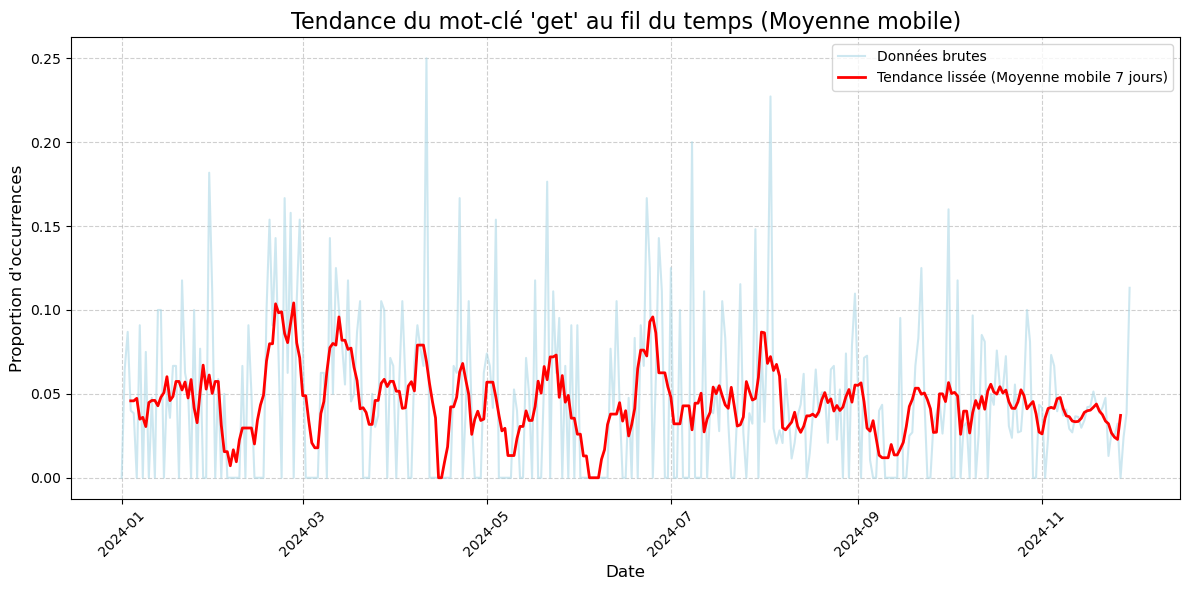

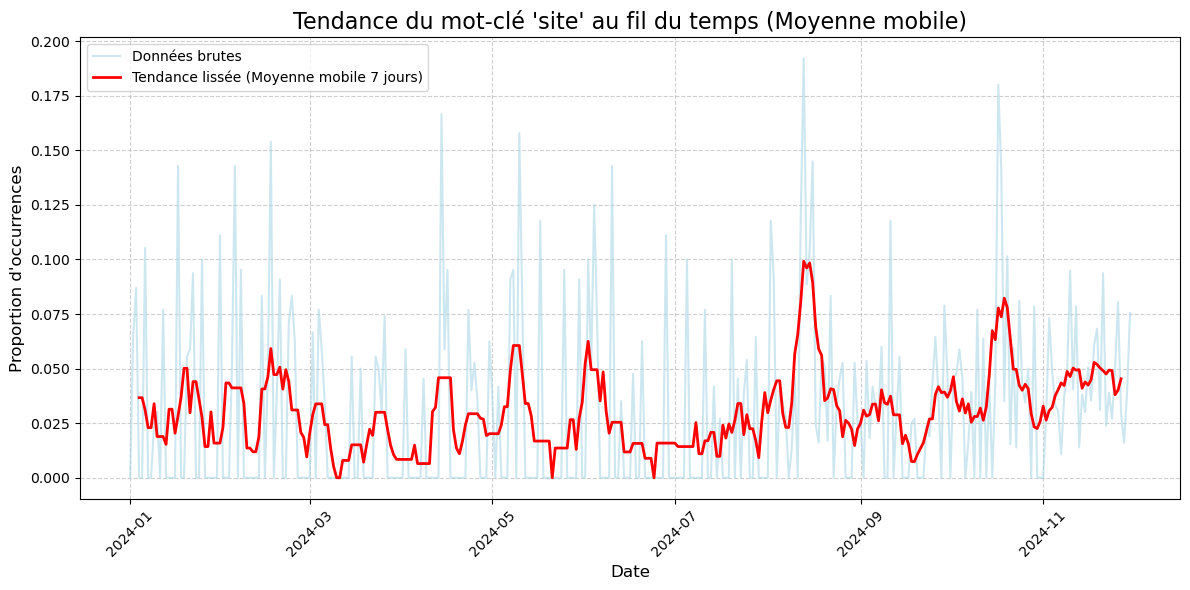

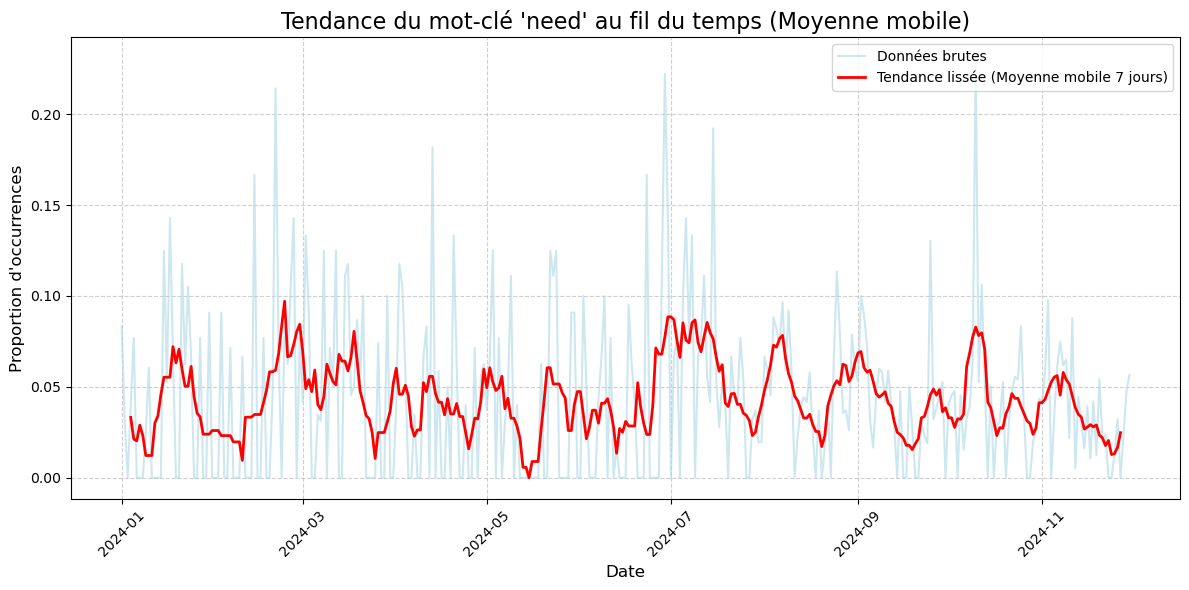

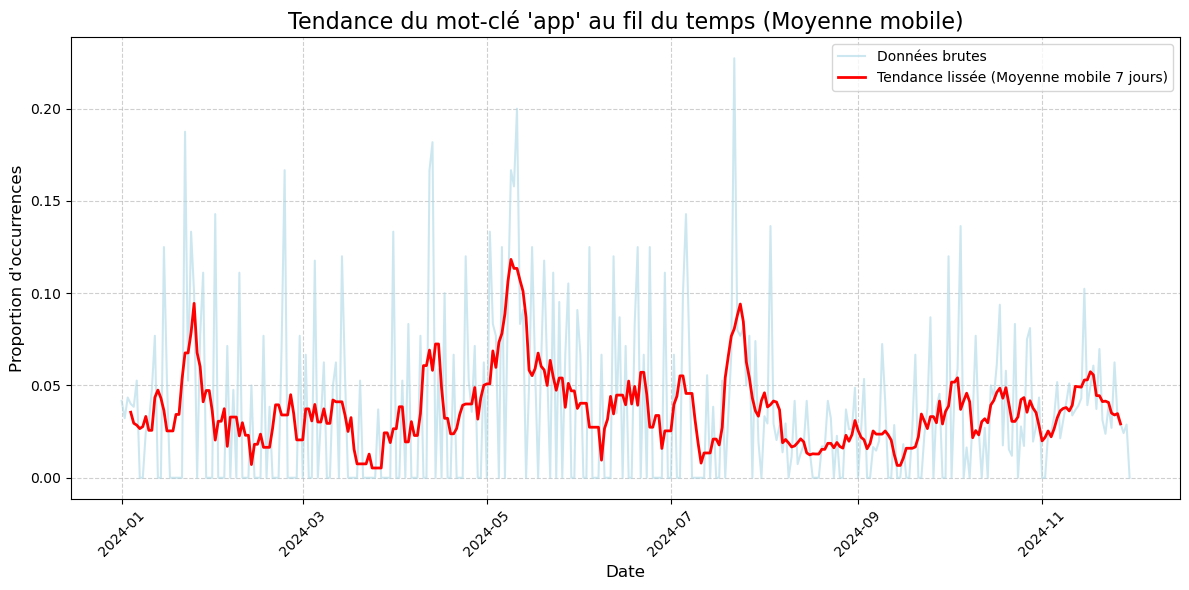

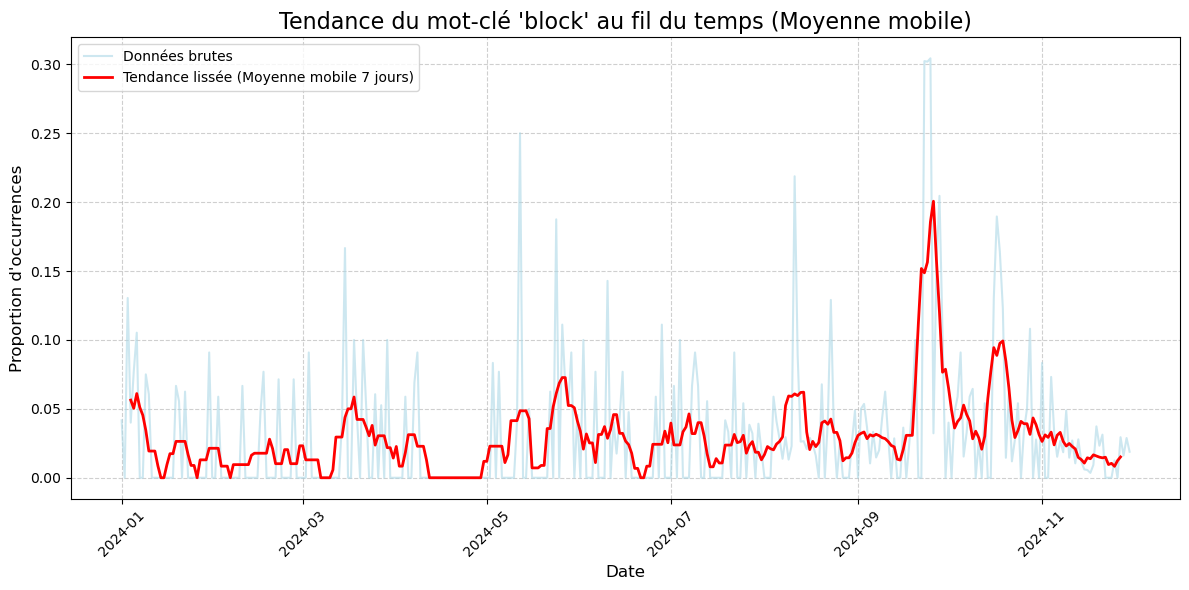

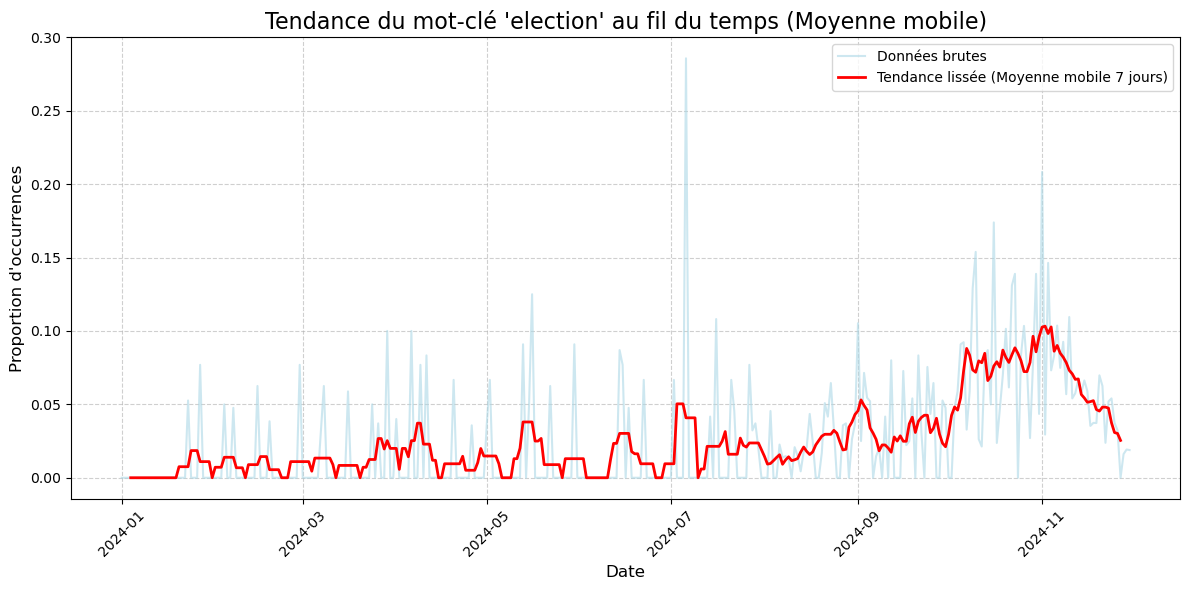

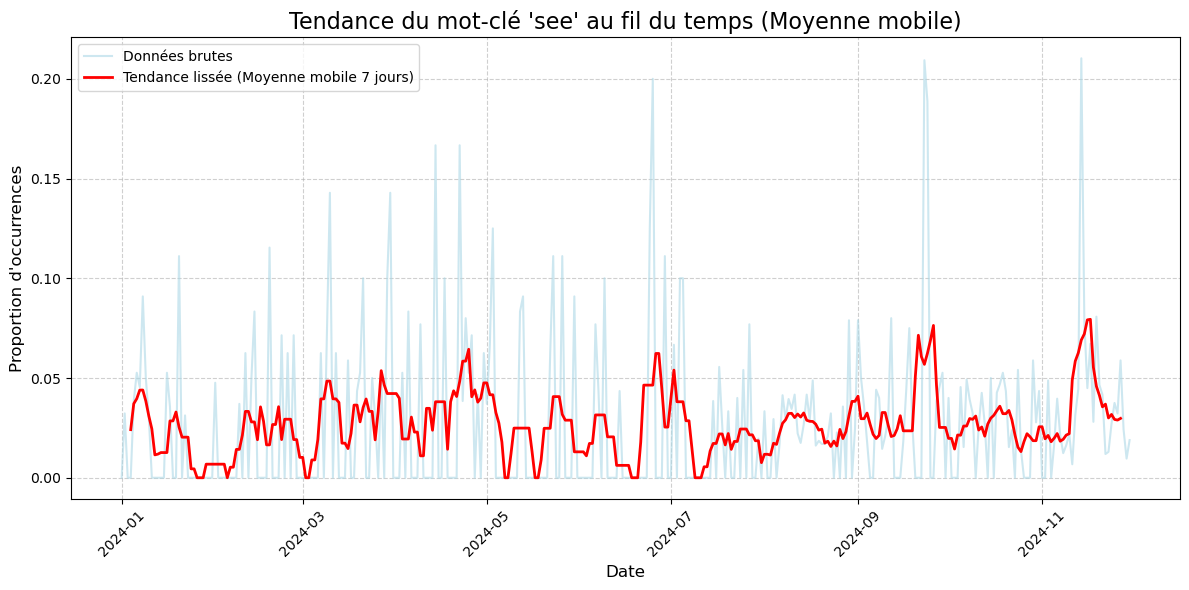

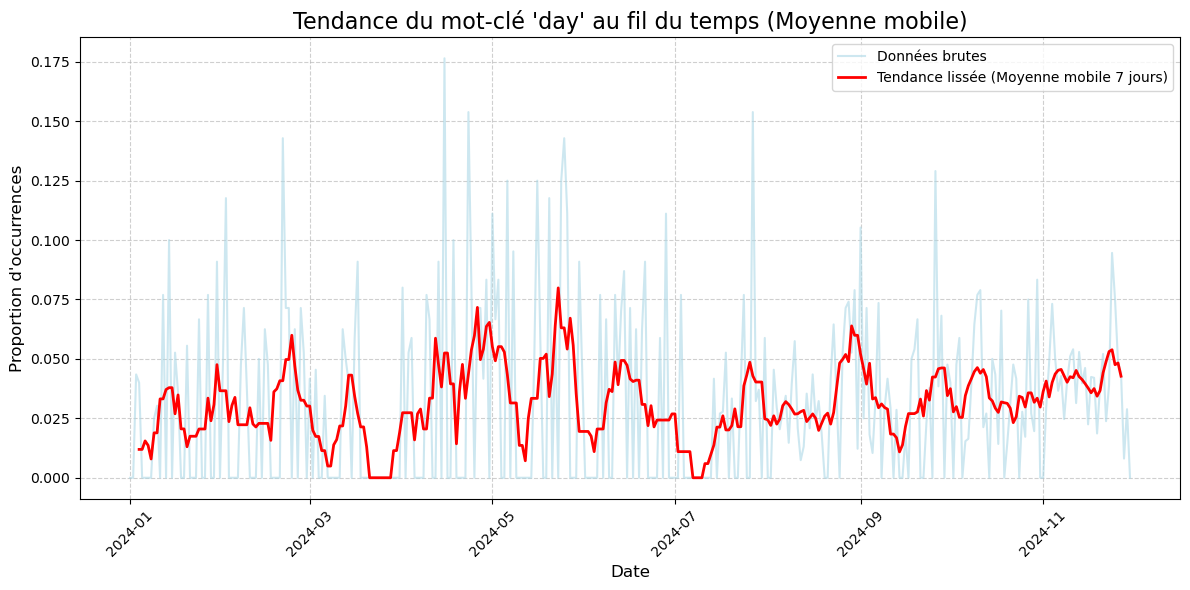

In [42]:
df['ConvertedDate'] = pd.to_datetime(df['ConvertedDate'], errors='coerce')

for word in fd['Word']:
    mot_cle = word
    df['mention'] = df['tokens'].apply(lambda tokens: mot_cle in tokens)
    total_tweets = df.groupby(df['ConvertedDate'].dt.date).size()
    occurrences = df[df['mention']].groupby(df['ConvertedDate'].dt.date).size()
    all_days = pd.date_range(start='2024-01-01', end='2024-11-30')
    occurrences = occurrences.reindex(all_days, fill_value=0)
    proportion = occurrences / total_tweets

    proportion = proportion.reindex(all_days, fill_value=0)

    rolling_window = 7  
    rolling_mean = proportion.rolling(window=rolling_window, center=True).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(proportion.index, proportion.values, label='Données brutes', color='#ADD8E6', alpha=0.6)
    plt.plot(proportion.index, rolling_mean, label=f'Tendance lissée (Moyenne mobile {rolling_window} jours)', color='red', linewidth=2)

# Ajouter des détails au graphique
    plt.title(f"Tendance du mot-clé '{word}' au fil du temps (Moyenne mobile)", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Proportion d'occurrences", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [33]:
df.head()

Username    Date  \
0                       𝐇𝐎𝐓𝐄𝐏 悪いバナー  Nov 30   
1               StraitjacketEnjoyer  Nov 30   
2  Juan Sánchez Villa-Lobos Ramírez  Nov 30   
3             MercadoMagico.com USA  Nov 30   
4                       Donel Adams  Nov 30   

                                             Content  Comments  Repost  Likes  \
0  The left have become so dependent on Twitter t...         1       0      0   
1  Have not noticed anything out of the ordinary ...         0       0      0   
2  Change to Twitter Suggests Elon Musk Is Panick...         0       0      0   
3  Change to Twitter Suggests Elon Musk Is Panick...         0       2      0   
4  Change to Twitter Suggests Elon Musk Is Panick...         0       0      0   

   Views ConvertedDate YearWeek YearMonth  \
0     49    2024-11-30      NaT   2024-11   
1     47    2024-11-30      NaT   2024-11   
2     17    2024-11-30      NaT   2024-11   
3     43    2024-11-30      NaT   2024-11   
4     22    2024-11-30      NaT   2024-11   

                                       cleaned_tweet  violence_prédite  \
0  the left have become so dependent on twitter t...                 0   
1  have not noticed anything out of the ordinary ...                 0   
2  change to twitter suggests elon musk is panick...                 0   
3  change to twitter suggests elon musk is panick...                 0   
4  change to twitter suggests elon musk is panick...                 0   

                                              tokens  mention  
0  [left, dependent, force, option, platform, fee...    False  
1  [notice, ordinary, buy, annoying, block, speci...    False  
2                  [change, suggest, panic, bluesky]    False  
3                  [change, suggest, panic, bluesky]    False  
4                  [change, suggest, panic, bluesky]    False

In [43]:
df_non_violent = df[df['violence_prédite'] == 0]
df_violent = df[df['violence_prédite'] == 1]

liste_non_violent = []
for ligne in df_non_violent['tokens']:
    liste_non_violent = liste_non_violent + ligne
liste_non_violent = [token for token in liste_non_violent if len(token) > 1]

fdist_non_violent = FreqDist(liste_non_violent)
fd_non_violent = pd.DataFrame(fdist_non_violent.most_common(30), columns = ["Word","Frequency"]).drop([0]).reindex()
fig = px.bar(fd_non_violent, x="Word", y="Frequency")
fig.update_traces(marker_color='rgb(240,128,128)',marker_line_color='rgb(8,48,107)',marker_line_width=1.5, opacity=0.8)
fig.show()


liste_violent = []
for ligne in df_violent['tokens']:
    liste_violent = liste_violent + ligne
liste_violent = [token for token in liste_violent if len(token) > 1]

fdist_violent = FreqDist(liste_violent)
fd_violent = pd.DataFrame(fdist_violent.most_common(30), columns = ["Word","Frequency"]).drop([0]).reindex()
fig = px.bar(fd_violent, x="Word", y="Frequency")
fig.update_traces(marker_color='rgb(240,128,128)',marker_line_color='rgb(8,48,107)',marker_line_width=1.5, opacity=0.8)
fig.show()

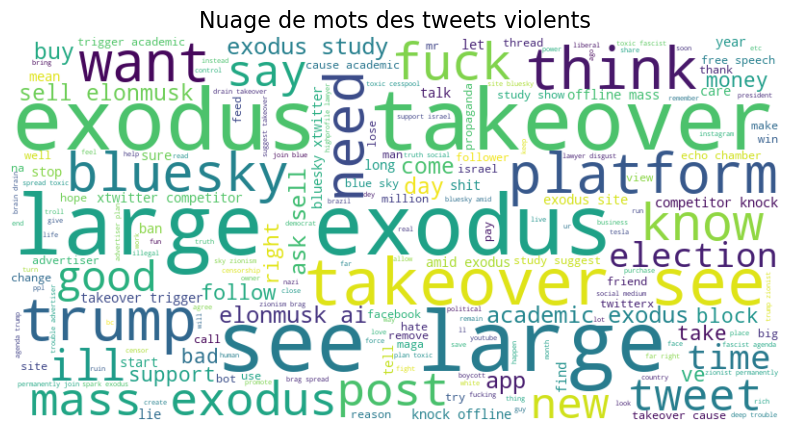

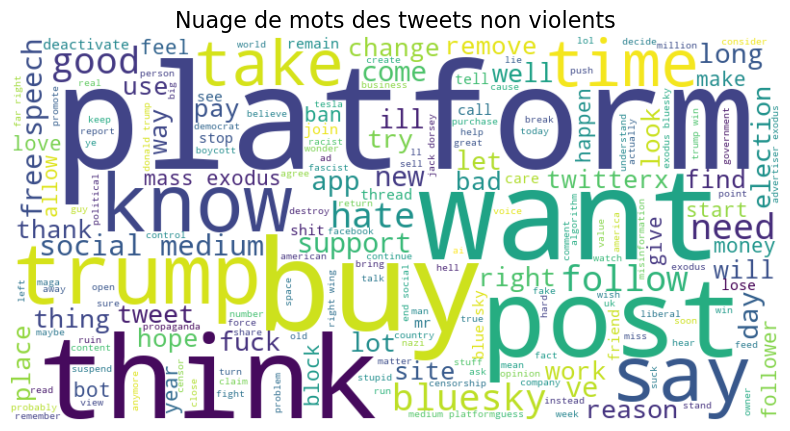

In [44]:
# Créer un Wordcloud pour les tweets violents et non violents
text_violent = ' '.join(liste_violent)
text_non_violent = ' '.join(liste_non_violent)

# Wordcloud pour les tweets violents
wordcloud_violent = WordCloud(width=800, height=400, background_color='white').generate(text_violent)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_violent, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots des tweets violents", fontsize=16)
plt.show()

# Wordcloud pour les tweets non violents
wordcloud_non_violent = WordCloud(width=800, height=400, background_color='white').generate(text_non_violent)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_non_violent, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots des tweets non violents", fontsize=16)
plt.show()


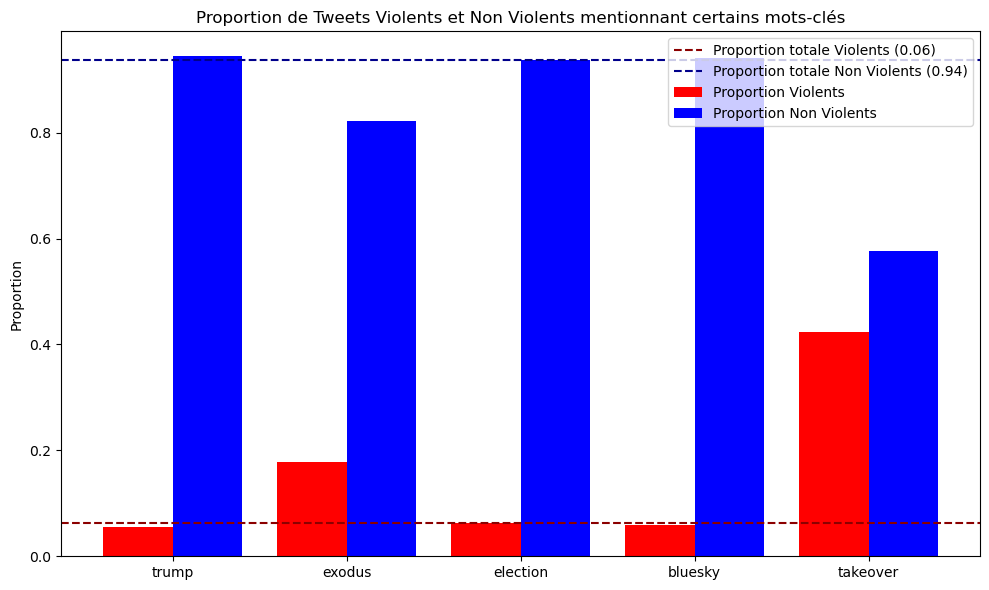

In [49]:
#on va sélectionner certains mots et regarder la proportion de tweets dits violents et non violents 
# qui mentionnent ces mots, cela en tenant compte de la proportion totale de tweets violents et 
#non violents

import matplotlib.pyplot as plt
import numpy as np

# Liste des mots-clés
keywords = ["trump", "exodus", "election", "bluesky","takeover"]

# Initialisation des résultats pour les proportions
proportions_violent = []
proportions_non_violent = []

# Calcul des proportions pour chaque mot-clé
for mot_cle in keywords:
    # Filtrer les tweets mentionnant le mot-clé
    df_mention_mot_cle = df[df['tokens'].apply(lambda tokens: mot_cle.lower() in tokens)]
    
    # Calcul des proportions
    proportion_violent = df_mention_mot_cle[df_mention_mot_cle['violence_prédite'] == 1].shape[0] / df_mention_mot_cle.shape[0]
    proportion_non_violent = df_mention_mot_cle[df_mention_mot_cle['violence_prédite'] == 0].shape[0] / df_mention_mot_cle.shape[0]
    
    # Ajouter les résultats
    proportions_violent.append(proportion_violent)
    proportions_non_violent.append(proportion_non_violent)

# Calcul des proportions totales de tweets violents et non violents
total_violent = df[df['violence_prédite'] == 1].shape[0]
total_non_violent = df[df['violence_prédite'] == 0].shape[0]
proportion_total_violent = total_violent / (total_violent + total_non_violent)
proportion_total_non_violent = total_non_violent / (total_violent + total_non_violent)

# Création du graphique
x = np.arange(len(keywords))  # Position des mots-clés sur l'axe X

fig, ax = plt.subplots(figsize=(10, 6))

# Barres pour les proportions de tweets violents
ax.bar(x - 0.2, proportions_violent, 0.4, label='Proportion Violents', color='red')

# Barres pour les proportions de tweets non violents
ax.bar(x + 0.2, proportions_non_violent, 0.4, label='Proportion Non Violents', color='blue')

# Ajouter les lignes horizontales pour les proportions totales
ax.axhline(y=proportion_total_violent, color='darkred', linestyle='--', label=f'Proportion totale Violents ({proportion_total_violent:.2f})')
ax.axhline(y=proportion_total_non_violent, color='darkblue', linestyle='--', label=f'Proportion totale Non Violents ({proportion_total_non_violent:.2f})')

# Ajouter des détails au graphique
ax.set_xticks(x)
ax.set_xticklabels(keywords)
ax.set_ylabel('Proportion')
ax.set_title('Proportion de Tweets Violents et Non Violents mentionnant certains mots-clés')
ax.legend()

# Afficher le graphique
plt.tight_layout()
plt.show()